<a href="https://colab.research.google.com/github/Sithakann/Braintumor_finalproject/blob/main/Sithakann_6538127_Brain_tumor_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install kaggle

In [ ]:
!pip install gradio

In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download masoudnickparvar/brain-tumor-mri-dataset

100% 148M/149M [00:06<00:00, 25.4MB/s]
100% 149M/149M [00:06<00:00, 24.0MB/s]


In [ ]:
! unzip brain-tumor-mri-dataset.zip

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import gradio as gr
from PIL import Image
import numpy as np
import numpy as np
from statistics import mode

In [9]:
torch.cuda.empty_cache()

In [10]:
# Define the transforms to be applied to the image data
transform = transforms.Compose([transforms.Resize((224, 224)), 
                                transforms.ToTensor(), 
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [11]:
train_dataset = ImageFolder('/content/Training', transform=transform)
validation_dataset = ImageFolder('/content/Testing', transform=transform)

In [12]:
train_num = len(train_dataset)
val_num = len(validation_dataset)
print("using {} images for training, {} images for validation.".format(train_num, val_num))

using 5712 images for training, 1311 images for validation.


In [13]:
class_count = {}
for image, label in train_dataset:
    class_name = train_dataset.classes[label]
    if class_name in class_count:
        class_count[class_name] += 1
    else:
        class_count[class_name] = 1

max = 0
for label, count in class_count.items():
    print("Class {}: {} examples".format(label, count))
    if count > max:
      baseline_class = count
      max = count

Class glioma: 1321 examples
Class meningioma: 1339 examples
Class notumor: 1595 examples
Class pituitary: 1457 examples


In [14]:
baseline_acc = baseline_class / train_num
# print(baseline_class)
print("Baseline accuracy:", baseline_acc)

Baseline accuracy: 0.27923669467787116


In [15]:
vgg16 = models.vgg16(pretrained=True)
for param in vgg16.parameters():
    param.requires_grad = False

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 252MB/s]


In [16]:
num_classes = 4
vgg16.classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(),
    nn.Linear(4096, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(),
    nn.Linear(4096, num_classes),
    nn.LogSoftmax(dim=1)
)

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vgg16.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [18]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001, momentum=0.9)

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Epoch [1/20], Train Loss: 0.5649, Train Accuracy: 79.24%
Epoch [1/20], Val Loss: 0.3603, Val Accuracy: 85.20%


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Epoch [2/20], Train Loss: 0.2338, Train Accuracy: 91.37%
Epoch [2/20], Val Loss: 0.2965, Val Accuracy: 88.33%


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Epoch [3/20], Train Loss: 0.1547, Train Accuracy: 94.52%
Epoch [3/20], Val Loss: 0.2018, Val Accuracy: 91.69%


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Epoch [4/20], Train Loss: 0.1156, Train Accuracy: 96.10%
Epoch [4/20], Val Loss: 0.1829, Val Accuracy: 93.06%


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Epoch [5/20], Train Loss: 0.0780, Train Accuracy: 97.46%
Epoch [5/20], Val Loss: 0.1494, Val Accuracy: 94.97%


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Epoch [6/20], Train Loss: 0.0557, Train Accuracy: 98.37%
Epoch [6/20], Val Loss: 0.1228, Val Accuracy: 95.58%


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Epoch [7/20], Train Loss: 0.0459, Train Accuracy: 98.53%
Epoch [7/20], Val Loss: 0.1419, Val Accuracy: 94.58%


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Epoch [8/20], Train Loss: 0.0300, Train Accuracy: 99.12%
Epoch [8/20], Val Loss: 0.1105, Val Accuracy: 96.49%


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Epoch [9/20], Train Loss: 0.0178, Train Accuracy: 99.61%
Epoch [9/20], Val Loss: 0.1215, Val Accuracy: 96.41%


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Epoch [10/20], Train Loss: 0.0208, Train Accuracy: 99.46%
Epoch [10/20], Val Loss: 0.1291, Val Accuracy: 95.65%


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Epoch [11/20], Train Loss: 0.0151, Train Accuracy: 99.65%
Epoch [11/20], Val Loss: 0.1134, Val Accuracy: 96.34%


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Epoch [12/20], Train Loss: 0.0102, Train Accuracy: 99.79%
Epoch [12/20], Val Loss: 0.1044, Val Accuracy: 96.34%


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Epoch [13/20], Train Loss: 0.0052, Train Accuracy: 99.96%
Epoch [13/20], Val Loss: 0.1206, Val Accuracy: 96.34%


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Epoch [14/20], Train Loss: 0.0049, Train Accuracy: 99.96%
Epoch [14/20], Val Loss: 0.1243, Val Accuracy: 96.49%


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Epoch [15/20], Train Loss: 0.0040, Train Accuracy: 99.98%
Epoch [15/20], Val Loss: 0.1252, Val Accuracy: 96.57%


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Epoch [16/20], Train Loss: 0.0036, Train Accuracy: 99.96%
Epoch [16/20], Val Loss: 0.1230, Val Accuracy: 96.41%


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Epoch [17/20], Train Loss: 0.0032, Train Accuracy: 99.98%
Epoch [17/20], Val Loss: 0.1228, Val Accuracy: 96.64%


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Epoch [18/20], Train Loss: 0.0034, Train Accuracy: 99.96%
Epoch [18/20], Val Loss: 0.1103, Val Accuracy: 96.64%


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Epoch [19/20], Train Loss: 0.0027, Train Accuracy: 99.98%
Epoch [19/20], Val Loss: 0.1082, Val Accuracy: 96.64%


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Epoch [20/20], Train Loss: 0.0021, Train Accuracy: 99.98%
Epoch [20/20], Val Loss: 0.1383, Val Accuracy: 96.26%


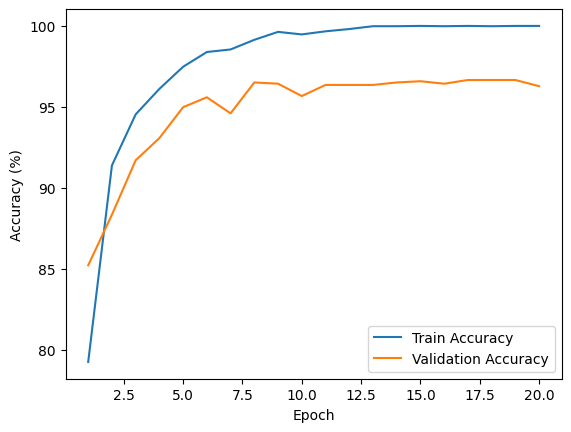

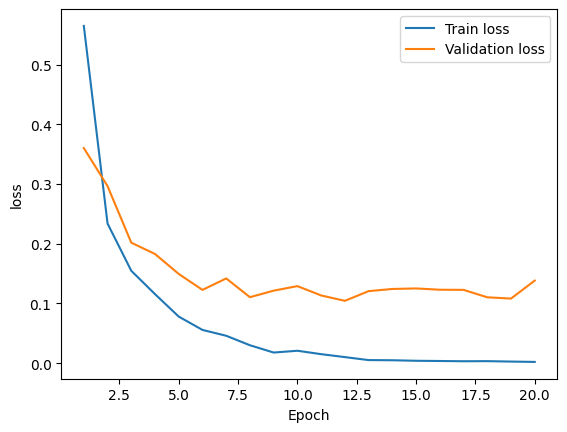

In [19]:
num_epochs = 20
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)


train_loss_list = []
train_accuracy_list = []
val_loss_list = []
val_accuracy_list = []

for epoch in range(num_epochs):
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    vgg16.train()
    for (inputs, labels) in tqdm(train_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = vgg16(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    vgg16.eval()
    with torch.no_grad():
        for (inputs, labels) in tqdm(val_dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = vgg16(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()    

    train_loss /= len(train_dataset)
    train_accuracy = 100 * train_correct / train_total
    train_loss_list.append(train_loss)
    train_accuracy_list.append(train_accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')
    val_loss /= len(validation_dataset)
    val_accuracy = 100 * val_correct / val_total
    val_loss_list.append(val_loss)
    val_accuracy_list.append(val_accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}], Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

# Plot the training loss and accuracy vs epoch
epochs = range(1, num_epochs+1)
# plt.plot(epochs, train_loss_list, label='Train Loss')
plt.plot(epochs, train_accuracy_list, label='Train Accuracy')
plt.plot(epochs, val_accuracy_list, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

# plt.plot(epochs, train_loss_list, label='Train Loss')
plt.plot(epochs, train_loss_list, label='Train loss')
plt.plot(epochs, val_loss_list, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [20]:
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes):
    """
    This function plots the confusion matrix for a given set of classes.
    """
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title='Confusion matrix',
           ylabel='True label',
           xlabel='Predicted label')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()

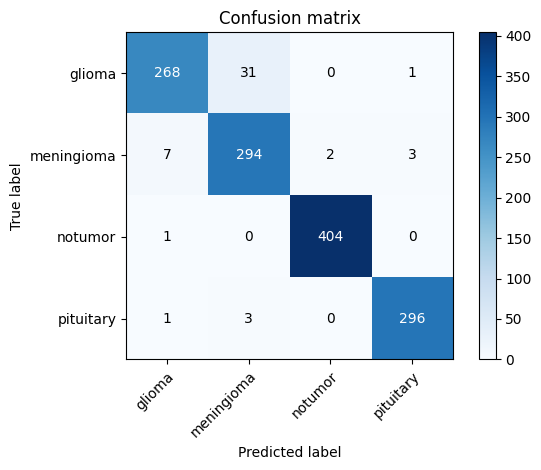

Accuracy on the test set: 0.9626
Recall on the test set: 0.9596
Loss on the test set: 0.1340
F1 on the test set: 0.9598
Precision on the test set: 0.9614
IOU on the test set: 0.9607


In [21]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, confusion_matrix, roc_curve, auc
import numpy as np
running_loss = 0.0
y_true = []
y_pred = []

with torch.no_grad():
      for images, labels in val_dataloader:
          images, labels = images.to(device), labels.to(device)
          outputs = vgg16(images)
          loss = criterion(outputs, labels)
          running_loss += loss.item() * inputs.size(0)

          probs = torch.nn.functional.softmax(outputs, dim=1)

          _, predictions = torch.max(outputs, 1)
          y_true += labels.tolist()
          y_pred += predictions.tolist()


accuracy = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
loss = running_loss / len(val_dataloader.dataset)
intersection = np.logical_and(y_true, y_pred)
union = np.logical_or(y_true, y_pred)
iou_score = np.sum(intersection) / np.sum(union)
cm = confusion_matrix(y_true, y_pred)
classes = val_dataloader.dataset.classes
plot_confusion_matrix(cm, classes)



print('Accuracy on the test set: {:.4f}' .format(accuracy))
print('Recall on the test set: {:.4f}'.format(recall))
print('Loss on the test set: {:.4f}'.format(loss))
print('F1 on the test set: {:.4f}'.format(f1))
print('Precision on the test set: {:.4f}'.format(precision))
print('IOU on the test set: {:.4f}'.format(iou_score))

In [22]:
def predict_image(img):
    img = Image.fromarray(np.uint8(img))
    img = transform(img).unsqueeze(0)
    img = img.to(device)
    with torch.no_grad():
        output = vgg16(img)
        probs = torch.softmax(output, dim=1)
    
    probs_dict = {f"class_{i}": prob.item() for i, prob in enumerate(probs[0])}
    probs_dict = {}
    for i, prob in enumerate(probs[0]):
        class_name = f"class_{i}"
        probs_dict[class_name] = prob.item()

    probs_dict = {
        "giloma": probs_dict["class_0"],
        "meningioma": probs_dict["class_1"],
        "notumor": probs_dict["class_2"],
        "pituitary": probs_dict["class_3"],
    }
    return probs_dict

In [ ]:
gr.Interface(fn=predict_image, 
             inputs=gr.Image(shape=(224,224)),
             outputs=gr.Label(num_top_classes=4)).launch(debug=True, share=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://a380eada4e9b973662.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces
